In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time
import country_converter as coco
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.graphics.api import qqplot
from sklearn.metrics import mean_squared_error

# Preparing Data for Modelling:
___

In [2]:
cities = pd.read_csv('Datasets/GlobalLandTemperaturesByCity.csv')

In [3]:
cities.shape                # We have 8.6 M rows of data

(8599212, 7)

In [4]:
cities.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [5]:
# Checking unique coutries:
cities['Country'].unique()

array(['Denmark', 'Turkey', 'Kazakhstan', 'China', 'Spain', 'Germany',
       'Nigeria', 'Iran', 'Russia', 'Canada', "Côte D'Ivoire",
       'United Kingdom', 'Saudi Arabia', 'Japan', 'United States',
       'India', 'Benin', 'United Arab Emirates', 'Mexico', 'Venezuela',
       'Ghana', 'Ethiopia', 'Australia', 'Yemen', 'Indonesia', 'Morocco',
       'Pakistan', 'France', 'Libya', 'Burma', 'Brazil', 'South Africa',
       'Syria', 'Egypt', 'Algeria', 'Netherlands', 'Malaysia', 'Portugal',
       'Ecuador', 'Italy', 'Uzbekistan', 'Philippines', 'Madagascar',
       'Chile', 'Belgium', 'El Salvador', 'Romania', 'Peru', 'Colombia',
       'Tanzania', 'Tunisia', 'Turkmenistan', 'Israel', 'Eritrea',
       'Paraguay', 'Greece', 'New Zealand', 'Vietnam', 'Cameroon', 'Iraq',
       'Afghanistan', 'Argentina', 'Azerbaijan', 'Moldova', 'Mali',
       'Congo (Democratic Republic Of The)', 'Thailand',
       'Central African Republic', 'Bosnia And Herzegovina', 'Bangladesh',
       'Switzerland'

In [6]:
usa =cities[cities['Country']== 'United States']

In [7]:
usa

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
47555,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W
47556,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W
47557,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W
47558,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W
47559,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W
...,...,...,...,...,...,...,...
8439242,2013-05-01,15.544,0.281,Yonkers,United States,40.99N,74.56W
8439243,2013-06-01,20.892,0.273,Yonkers,United States,40.99N,74.56W
8439244,2013-07-01,24.722,0.279,Yonkers,United States,40.99N,74.56W
8439245,2013-08-01,21.001,0.323,Yonkers,United States,40.99N,74.56W


### Focusing on USA data by sampling from some different cities:

In [8]:
usa_cities = usa[usa['City'].isin(['New York', 'Los Angeles', 'San Francisco'])]

In [9]:
usa_cities.head(3)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
4356748,1849-01-01,8.819,2.558,Los Angeles,United States,34.56N,118.70W
4356749,1849-02-01,9.577,1.970,Los Angeles,United States,34.56N,118.70W
4356750,1849-03-01,11.814,2.173,Los Angeles,United States,34.56N,118.70W


In [10]:
usa_cities = usa[['dt', 'AverageTemperature']]

In [11]:
usa_cities.head()

,dt,AverageTemperature
47555,1820-01-01,2.101
47556,1820-02-01,6.926
47557,1820-03-01,10.767
47558,1820-04-01,17.989
47559,1820-05-01,21.809


In [12]:
usa_cities.columns = ['date', 'temperature']

In [13]:
usa_cities.head()

,date,temperature
47555,1820-01-01,2.101
47556,1820-02-01,6.926
47557,1820-03-01,10.767
47558,1820-04-01,17.989
47559,1820-05-01,21.809


In [16]:
# converting date column into a datetime:

usa_cities['date'] = pd.to_datetime(usa_cities['date'])

/var/folders/b4/qnmj1swx0nx7h2b62nkjf05h0000gn/T/ipykernel_1465/448611960.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
# Checking for missing data:
usa_cities.isna().sum()

date               0
temperature    25765
dtype: int64

In [18]:
# Dropping missing missing values:
usa_cities.dropna(inplace=True)

/var/folders/b4/qnmj1swx0nx7h2b62nkjf05h0000gn/T/ipykernel_1465/1972313084.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
len(usa_cities)

661524

In [20]:
usa_cities.isna().sum()

date           0
temperature    0
dtype: int64

In [21]:
# Setting date as the index:
usa_cities.set_index('date', inplace=True)

In [22]:
usa_cities.head()

,temperature
date,
1820-01-01,2.101
1820-02-01,6.926
1820-03-01,10.767
1820-04-01,17.989
1820-05-01,21.809


In [23]:
usa_cities.index

DatetimeIndex(['1820-01-01', '1820-02-01', '1820-03-01', '1820-04-01',
               '1820-05-01', '1820-06-01', '1820-07-01', '1820-08-01',
               '1820-09-01', '1820-10-01',
               ...
               '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01',
               '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01'],
              dtype='datetime64[ns]', name='date', length=661524, freq=None)

## Checking for Seasonality:
- If seasonality exists in our data, that means our data is non-stationary and we will convert it into stationary data in order to optimize our time series model

### Creating a pivot table to plot the monthly temperatures through the years

In [25]:
# Adding a year column
usa_cities['year'] = usa_cities.index.year

/var/folders/b4/qnmj1swx0nx7h2b62nkjf05h0000gn/T/ipykernel_1465/3323485233.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
# Adding a month column
usa_cities['month'] = usa_cities.index.month

/var/folders/b4/qnmj1swx0nx7h2b62nkjf05h0000gn/T/ipykernel_1465/3362321603.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
# Creating a pivot table:
pivot = usa_cities.pivot_table(values = 'temperature', index='month', columns='year')

Text(0.5, 1.0, 'Yearly Seasonality')

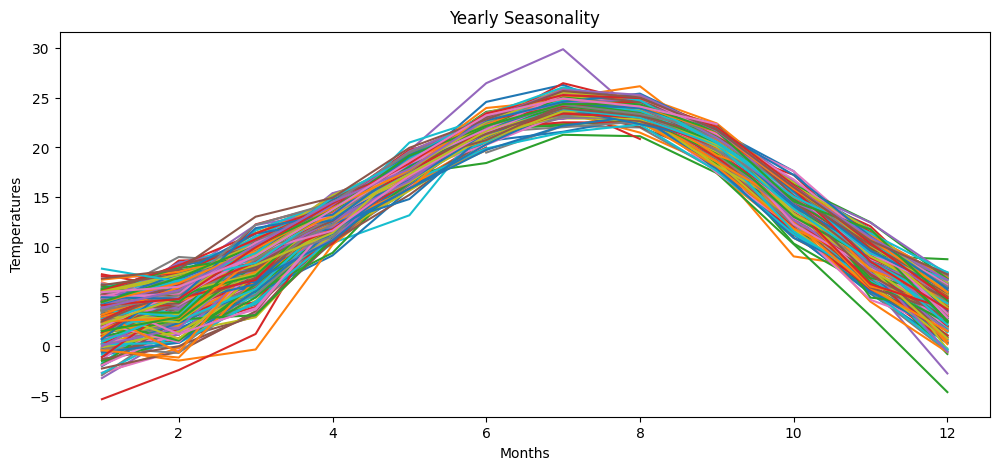

In [29]:
# Plotting:
pivot.plot(figsize=(12,5))
plt.legend().remove()
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.title('Yearly Seasonality')


## Findings:
- Now we can notice seasonality each year, temperature gets to peack during July and August, start to drop from september, and reaches the lowest temperature from December until Febuary.

# Baseline Model Using Moving Average:

In [43]:
# resampling data with a monthly start
usa_cities = usa_cities.resample('BMS').mean()

In [44]:
usa_cities.dropna(inplace=True)

In [45]:
usa_cities.isna().sum()

temperature    0
year           0
month          0
dtype: int64

<AxesSubplot: xlabel='date'>

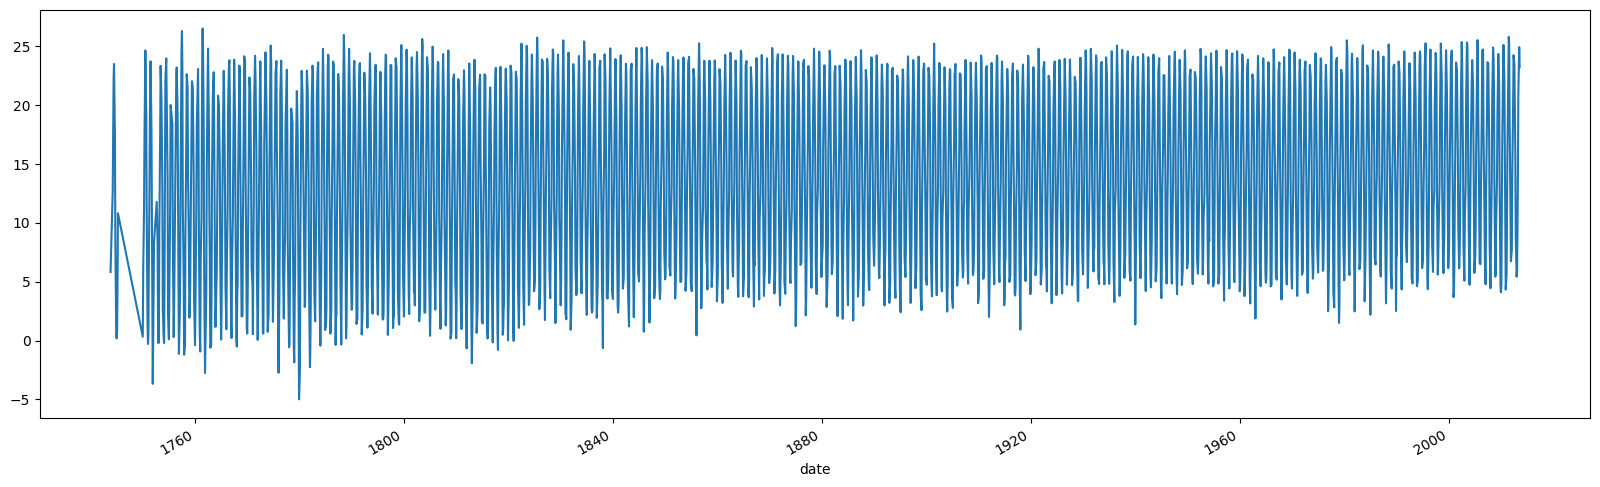

In [47]:
usa_cities['temperature'].plot(figsize=(20,6))

- Looking at the spread of the data we can see that our data is **seasonal** due to the large variance in the data

In [48]:
usa_cities

,temperature,year,month
date,,,
1743-11-01,5.818071,1743.0,11.000000
1744-04-01,12.760439,1744.0,4.000000
1744-05-01,17.082939,1744.0,5.000000
1744-06-01,22.232969,1744.0,6.000000
1744-07-01,23.499459,1744.0,7.000000
...,...,...,...
2013-03-01,9.071175,2013.0,3.000000
2013-04-01,13.750257,2013.0,4.000000
2013-05-01,20.934850,2013.0,5.500000


In [49]:
y = usa_cities['temperature']

In [50]:
y.index

DatetimeIndex(['1743-11-01', '1744-04-01', '1744-05-01', '1744-06-01',
               '1744-07-01', '1744-09-01', '1744-10-01', '1744-12-01',
               '1745-01-01', '1745-02-01',
               ...
               '2012-08-01', '2012-10-01', '2012-11-01', '2013-01-01',
               '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01',
               '2013-07-01', '2013-08-01'],
              dtype='datetime64[ns]', name='date', length=2318, freq=None)

Text(0.5, 1.0, 'True Data')

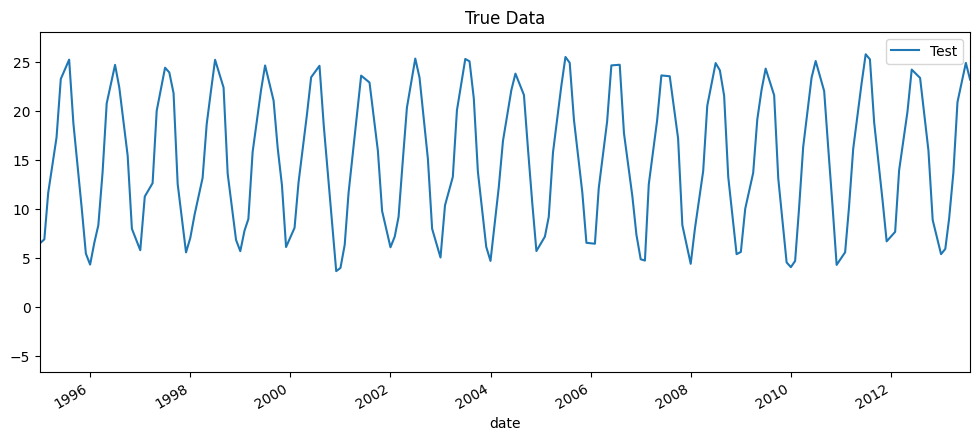

In [51]:
y.plot(legend=True, label='Test',xlim=['1995-01-01','2013-08-01'], figsize=(12,5))
plt.title('True Data')

#
___
## Establishing a baseline using moving average:

In [52]:

predictions = y.rolling(window=12).mean()
predictions.dropna(inplace=True)

<AxesSubplot: xlabel='date'>

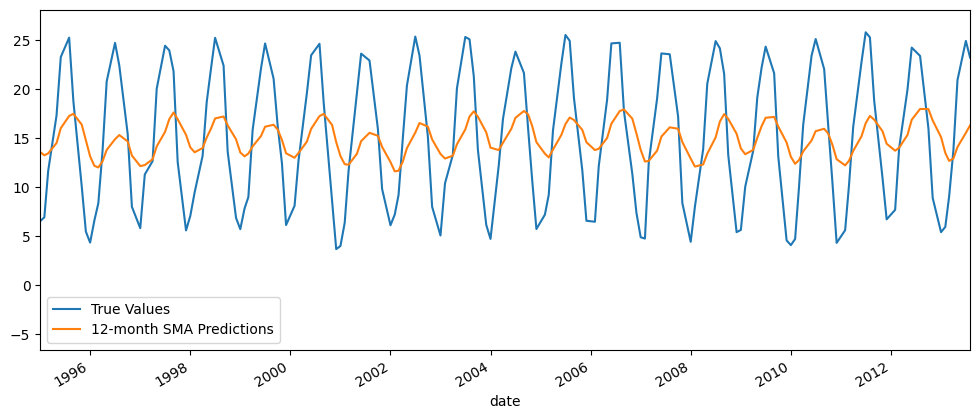

In [53]:
y.plot(legend=True, label='True Values',xlim=['1995-01-01','2013-08-01'], figsize=(12,5))
predictions.plot(legend=True, label='12-month SMA Predictions')


In [54]:
mean_squared_error(y.iloc[11:], predictions, squared=False)

6.62851997171216

In [55]:

predictions2 = y.rolling(window=6).mean()
predictions2.dropna(inplace=True)

Text(0.5, 1.0, 'True vs. Predictions')

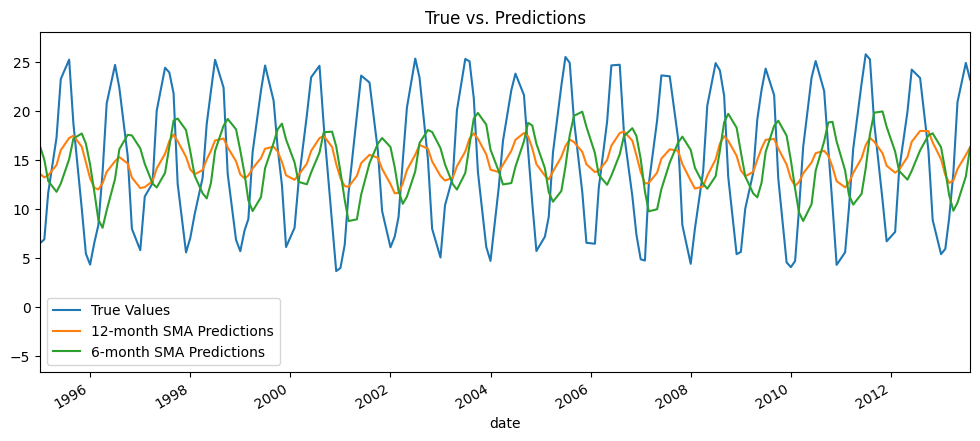

In [56]:
y.plot(legend=True, label='True Values',xlim=['1995-01-01','2013-08-01'], figsize=(12,5))
predictions.plot(legend=True, label='12-month SMA Predictions')
predictions2.plot(legend=True, label='6-month SMA Predictions')

plt.title('True vs. Predictions')

In [57]:
print(f' RMSE of 6-months SMA Model: {mean_squared_error(y.iloc[5:], predictions2, squared=False)}')
print(f' RMSE of 12-months SMA Model: {mean_squared_error(y.iloc[11:], predictions, squared=False)}')

 RMSE of 6-months SMA Model: 8.549974171928877
 RMSE of 12-months SMA Model: 6.62851997171216


### Findings:
- 12-months Simple Moving Average Model is doing a little better over the 6-months moving average model

### Predicting Using Exponentially Weighted Moving Average

In [58]:
predictions3 = y.ewm(span=12).mean()
predictions3.dropna(inplace=True)

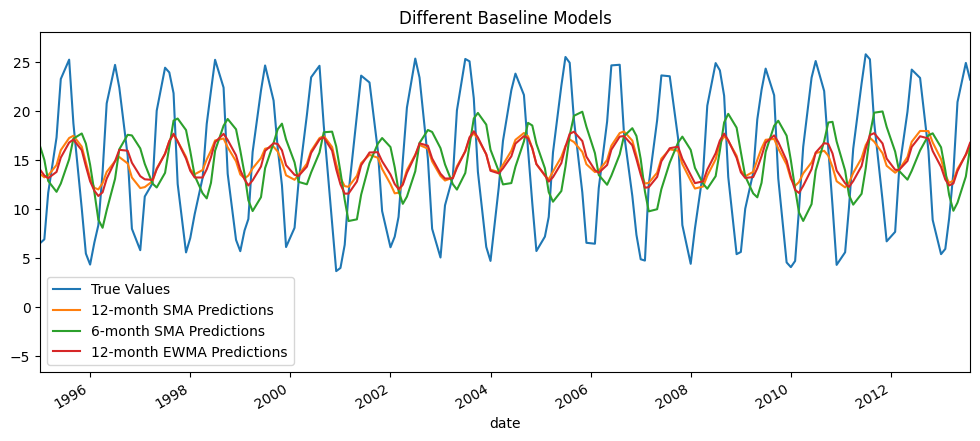

In [59]:
y.plot(legend=True, label='True Values',xlim=['1995-01-01','2013-08-01'], figsize=(12,5))
predictions.plot(legend=True, label='12-month SMA Predictions')
predictions2.plot(legend=True, label='6-month SMA Predictions')
predictions3.plot(legend=True, label='12-month EWMA Predictions')


plt.title('Different Baseline Models')
plt.savefig('Different Baseline Models')


In [60]:
print(f' RMSE of 6-months SMA Model: {mean_squared_error(y.iloc[5:], predictions2, squared=False)}')
print(f' RMSE of 12-months SMA Model: {mean_squared_error(y.iloc[11:], predictions, squared=False)}')
print(f' RMSE of 12-months EWMA Model: {mean_squared_error(y, predictions3, squared=False)}')

 RMSE of 6-months SMA Model: 8.549974171928877
 RMSE of 12-months SMA Model: 6.62851997171216
 RMSE of 12-months EWMA Model: 6.726025716869248


#
___

# Data Preparation for ARIMA Model:

### Checking Stationarity using ADF-Test:

In [61]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

Resource:
 - https://datascience.stackexchange.com/questions/74667/high-error-arima-model-python

In [62]:
adf_test(usa_cities['temperature'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -4.035965
p-value                    0.001233
# lags used               25.000000
# observations          2292.000000
critical value (1%)       -3.433206
critical value (5%)       -2.862802
critical value (10%)      -2.567442
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Findings:
- Based on this ADF test, our data is has evidence of non-stationarity and we will need to transform it into stationary data

### Transfoming data into stationary using differencing:

In [63]:
from statsmodels.tsa.statespace.tools import diff

In [64]:
usa_cities['temp_transformed'] = diff(usa_cities['temperature'], k_diff=1)

In [65]:
adf_test(usa_cities['temp_transformed'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -19.343112
p-value                    0.000000
# lags used               27.000000
# observations          2289.000000
critical value (1%)       -3.433210
critical value (5%)       -2.862804
critical value (10%)      -2.567443
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


<AxesSubplot: xlabel='date'>

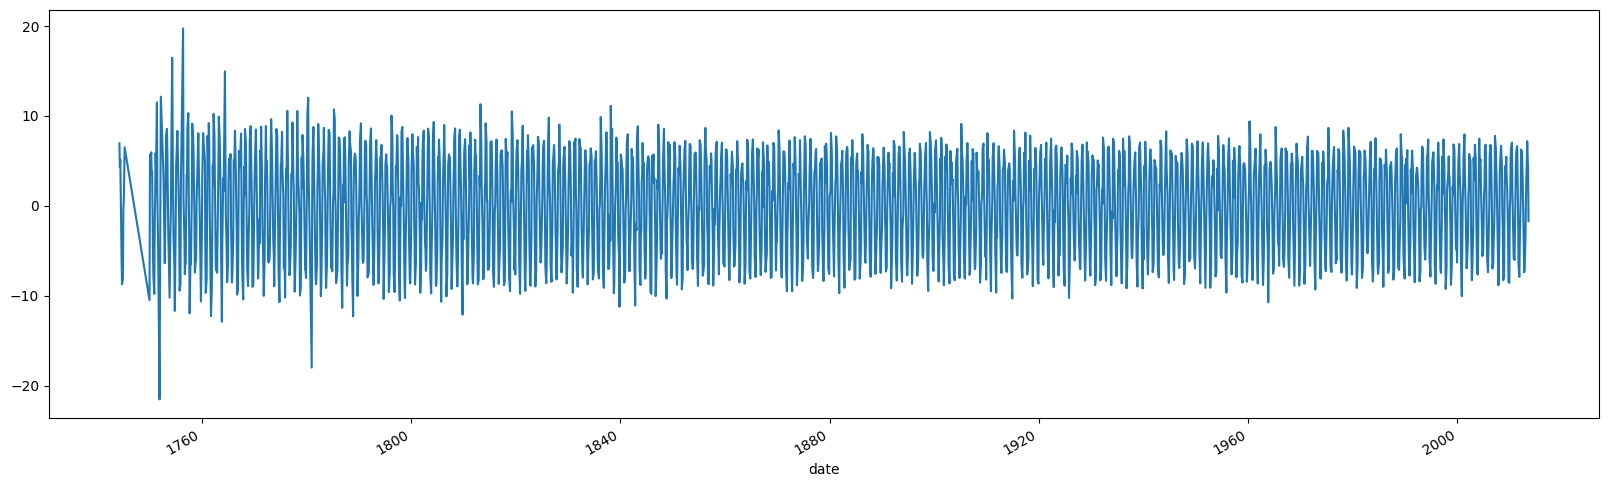

In [66]:
usa_cities['temp_transformed'].plot(figsize=(20,6))

- Now our data have been transformed from non-stationary into stationary and it's ready for time series modeling:

In [67]:
usa_cities

,temperature,year,month,temp_transformed
date,,,,
1743-11-01,5.818071,1743.0,11.000000,NaN
1744-04-01,12.760439,1744.0,4.000000,6.942367
1744-05-01,17.082939,1744.0,5.000000,4.322500
1744-06-01,22.232969,1744.0,6.000000,5.150031
1744-07-01,23.499459,1744.0,7.000000,1.266490
...,...,...,...,...
2013-03-01,9.071175,2013.0,3.000000,3.105537
2013-04-01,13.750257,2013.0,4.000000,4.679082
2013-05-01,20.934850,2013.0,5.500000,7.184593


In [68]:
df = usa_cities[['temperature', 'temp_transformed']]

In [69]:
df.dropna(inplace=True)

/var/folders/b4/qnmj1swx0nx7h2b62nkjf05h0000gn/T/ipykernel_1465/1379821321.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [70]:
df.head(3)

,temperature,temp_transformed
date,,
1744-04-01,12.760439,6.942367
1744-05-01,17.082939,4.322500
1744-06-01,22.232969,5.150031


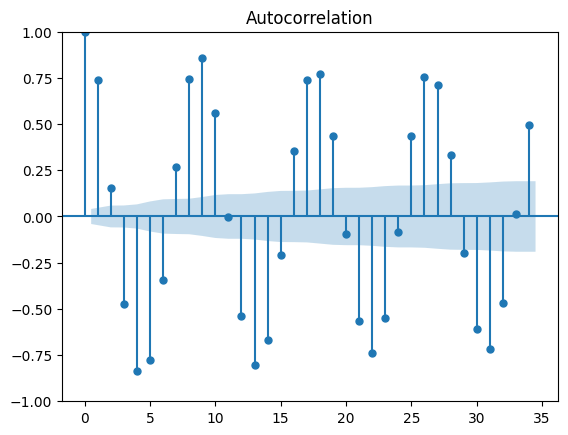

In [71]:
plot_acf(df['temperature']);
## q-3

/opt/anaconda3/envs/sktimeenv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



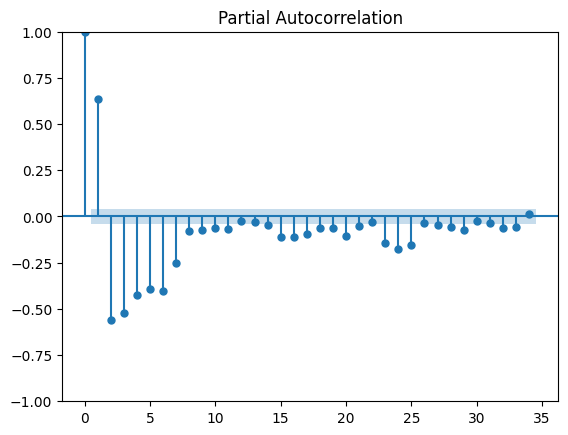

In [72]:
plot_pacf(df['temp_transformed']);


# Findings:
- Based on on these ACF and PACF plots I will consider my arima value q = 12 and p = 11

In [73]:
df = df[['temperature']]

In [74]:
df.isnull().sum()

temperature    0
dtype: int64

In [75]:
len(df)

2317

In [76]:
df = df.asfreq('MS',method='ffill')

In [77]:
df[df['temperature'].isnull()]

,temperature
date,


In [78]:
len(df)

3233

In [79]:
df.isnull().sum()

temperature    0
dtype: int64

In [80]:
training_data=df.iloc[:len(df)-24]
testing_data=df.iloc[len(df)-24:]

In [81]:
training_data.tail()

,temperature
date,
2011-04-01,16.178220
2011-05-01,16.178220
2011-06-01,22.822560
2011-07-01,25.804588
2011-08-01,25.289844


In [82]:
testing_data.tail()

,temperature
date,
2013-04-01,13.750257
2013-05-01,20.934850
2013-06-01,20.934850
2013-07-01,24.925054
2013-08-01,23.224940


In [83]:
from statsmodels.tsa.arima.model import ARIMA

In [84]:
arima=ARIMA(training_data,order=(12,1,11)) #

In [85]:
arima_model=arima.fit()

/opt/anaconda3/envs/sktimeenv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [86]:
start = len(training_data)
end= len(training_data) + len(testing_data)-1

In [87]:
start

3209

In [88]:
pred=arima_model.predict(start = start, end=end)

In [89]:
pred.head()

2011-09-01    20.011694
2011-10-01    17.565640
2011-11-01    10.750418
2011-12-01     5.401679
2012-01-01     5.121916
Freq: MS, Name: predicted_mean, dtype: float64

In [90]:
testing_data.head()

,temperature
date,
2011-09-01,18.840669
2011-10-01,18.840669
2011-11-01,10.934926
2011-12-01,6.736379
2012-01-01,6.736379


In [91]:
training_data['temperature']['2000-01-01':]

date
2000-01-01     6.156292
2000-02-01     8.115903
2000-03-01    12.737066
2000-04-01    12.737066
2000-05-01    19.614455
                ...    
2011-04-01    16.178220
2011-05-01    16.178220
2011-06-01    22.822560
2011-07-01    25.804588
2011-08-01    25.289844
Freq: MS, Name: temperature, Length: 140, dtype: float64

Text(0.5, 1.0, 'ARIMA Predictions Vs. Testing Data')

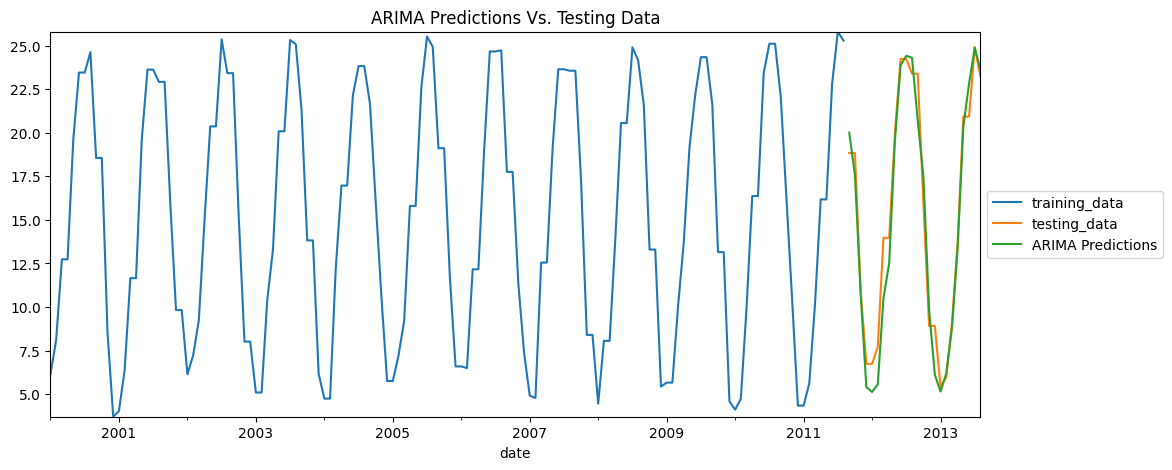

In [92]:
ax = training_data['temperature']['2000-01-01':].plot(legend=True, label='training_data', figsize=(12,5))
testing_data['temperature'].plot(legend=True, label='testing_data')

ax.autoscale(axis='both', tight=True)

pred.plot(legend=True, label = 'ARIMA Predictions')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('ARIMA Predictions Vs. Testing Data')


In [93]:
mean_squared_error(testing_data, pred, squared=False)

1.4399754866076266

# Findings:
- Now we can notice that our ARIMA model is performing with a mse of 1.4, which is better than or baseline moving average model with mse of 6.46.

### Finding the best model with Auto_arima:

In [94]:
from pmdarima.arima import auto_arima

In [95]:
model = auto_arima(training_data['temperature'], trace=True, m=12,
                  max_order=None,
                  n_jobs = -1)

/opt/anaconda3/envs/sktimeenv/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=7.30 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=18971.841, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=16116.534, Time=1.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=17392.224, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=18969.843, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=18519.204, Time=0.20 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=3.14 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=3.26 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=17391.170, Time=0.85 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=14.18 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=16832.445, Time=0.56 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=4.77 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=4.99 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=inf

In [105]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3209
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood               -8054.267
Date:                            Sat, 12 Nov 2022   AIC                          16114.534
Time:                                    07:09:16   BIC                          16132.754
Sample:                                04-01-1744   HQIC                         16121.065
                                     - 08-01-2011                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4911      0.012    -41.066      0.000      -0.514      -0.468
ar.S.L12       0.8631      0.008    112.597      0.000       0.848       0.878
sigma2         8.8312      0.187     47.317      0.000       8.465       9.197
===================================================================================
Ljung-Box (L1) (Q):                  62.58   Jarque-Bera (JB):               112.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [106]:
pred2 = model.predict(len(testing_data))

In [107]:
pred2

2011-09-01    22.898498
2011-10-01    17.727321
2011-11-01    12.741725
2011-12-01     7.514098
2012-01-01     7.528796
2012-02-01     8.632648
2012-03-01    12.553747
2012-04-01    17.743559
2012-05-01    17.744413
2012-06-01    23.478765
2012-07-01    26.052777
2012-08-01    25.608398
2012-09-01    23.544462
2012-10-01    19.081163
2012-11-01    14.778076
2012-12-01    10.266073
2013-01-01    10.278762
2013-02-01    11.231502
2013-03-01    14.615828
2013-04-01    19.095186
2013-05-01    19.095923
2013-06-01    24.045278
2013-07-01    26.266924
2013-08-01    25.883377
Freq: MS, dtype: float64

In [108]:
mean_squared_error(testing_data, pred2, squared=False)

3.1035801101779636

# Findings:
- Based on our auto_arima model's result we can still conclude that our previous ARIMA model with parameters (12,1,11) is still outperforming the suggested model from auto_arima

# Forecasting for 10 years in the future

In [109]:
# Using the entire data for training
arima=ARIMA(df,order=(12,1,11)) #

In [110]:
arima_model=arima.fit()

/opt/anaconda3/envs/sktimeenv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [111]:
start = len(df)
end= len(df)+119

In [112]:
pred=arima_model.predict(start = start, end=end, type='levels').rename('ARIMA FORECAST')

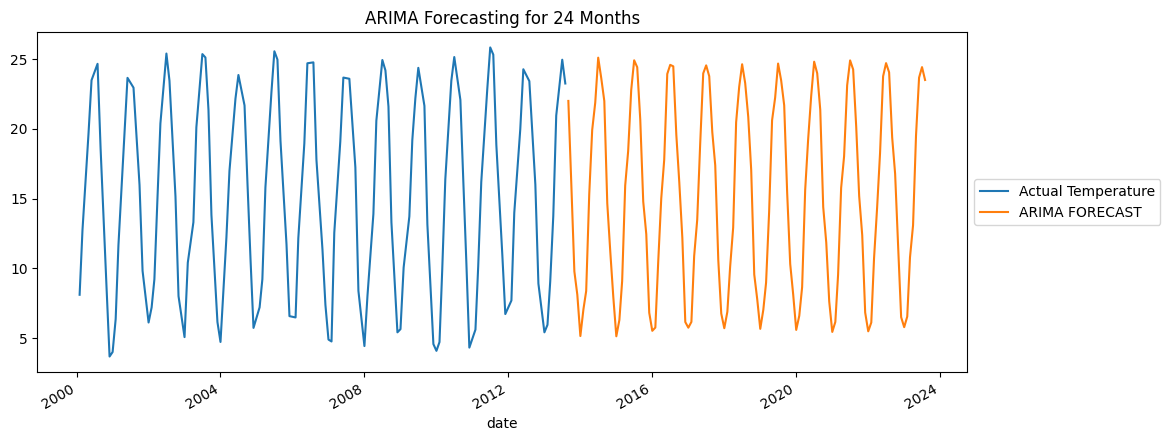

In [113]:
ax = usa_cities['temperature']['2000-01-01':].plot(legend=True, label='Actual Temperature', figsize=(12,5))
pred.plot(legend=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('ARIMA Forecasting for 24 Months');
